In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Memoria GPU configurada correctamente")
    except RuntimeError as e:
        print(e)

✓ Memoria GPU configurada correctamente


In [3]:
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K


In [4]:
#1. Cargar los splits generados en Notebook 04
import pandas as pd

train_df = pd.read_csv("train_split.csv")
val_df   = pd.read_csv("val_split.csv")
test_df  = pd.read_csv("test_split.csv")

len(train_df), len(val_df), len(test_df)

(319, 57, 67)

In [5]:
#2. Función para convertir el DataFrame → tf.data.Dataset

TARGET_SIZE = (384, 384)

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, TARGET_SIZE)
    return img

def load_mask(path):
    mask = tf.io.read_file(path)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, TARGET_SIZE)
    mask = tf.where(mask > 0, 1.0, 0.0)
    return mask

def load_pair(img_path, mask_path):
    img = load_image(img_path)
    mask = load_mask(mask_path)
    return img, mask

def df_to_dataset(df, shuffle=True):
    img_paths = df["img"].values
    mask_paths = df["mask"].values

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda x, y: load_pair(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(512)

    return ds

In [6]:
#3. Crear los datasets finales

BATCH_SIZE = 4

train_ds = df_to_dataset(train_df)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = df_to_dataset(val_df, shuffle=False)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = df_to_dataset(test_df, shuffle=False)
test_ds = test_ds.batch(BATCH_SIZE)

In [7]:
#4. Métricas y funciones de pérdida (Dice + BCE)

def dice_coef(y_true, y_pred, smooth=1e-6):
    #Dice Coefficient
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    #Dice loss
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    #Binary Cross-Entropy + Dice Loss
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc



In [8]:
#5. Bloques de la U-Net

def conv_block(x, filters):
    #Bloque conv (Conv → BN → ReLU → Conv → BN → ReLU)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

def up_block(x, skip, filters):
    #Bloque de upsampling
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

In [9]:
#6. Arquitectura U-Net (384×384×1)
def build_unet(input_shape=(384, 384, 1), filters=32):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, filters);       p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, filters*2);         p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, filters*4);         p3 = layers.MaxPool2D()(c3)
    c4 = conv_block(p3, filters*8);         p4 = layers.MaxPool2D()(c4)

    # Bottleneck
    bn = conv_block(p4, filters*16)

    # Decoder
    u1 = up_block(bn, c4, filters*8)
    u2 = up_block(u1, c3, filters*4)
    u3 = up_block(u2, c2, filters*2)
    u4 = up_block(u3, c1, filters)

    # Output
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(u4)

    return models.Model(inputs, outputs)

In [10]:
#7. Construir el modelo
model = build_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
#8. Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=["accuracy", dice_coef]
)

In [12]:
#9. Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10, monitor="val_loss", restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "unet_best_model.h5", monitor="val_loss", save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=4, min_lr=1e-7
    ),
    tf.keras.callbacks.TensorBoard(log_dir="logs")
]


In [13]:
#10. Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
80/80 [==============================] - 1099s 303ms/step - loss: 0.8003 - accuracy: 0.8934 - dice_coef: 0.5012 - val_loss: 1.3169 - val_accuracy: 0.8697 - val_dice_coef: 0.1892 - lr: 1.0000e-04
Epoch 2/60
80/80 [==============================] - 22s 272ms/step - loss: 0.5405 - accuracy: 0.9510 - dice_coef: 0.6422 - val_loss: 1.2624 - val_accuracy: 0.8697 - val_dice_coef: 0.1348 - lr: 1.0000e-04
Epoch 3/60
80/80 [==============================] - 21s 264ms/step - loss: 0.4588 - accuracy: 0.9620 - dice_coef: 0.6923 - val_loss: 1.2913 - val_accuracy: 0.8697 - val_dice_coef: 0.1078 - lr: 1.0000e-04
Epoch 4/60
80/80 [==============================] - 21s 262ms/step - loss: 0.4097 - accuracy: 0.9670 - dice_coef: 0.7226 - val_loss: 1.3245 - val_accuracy: 0.8697 - val_dice_coef: 0.0897 - lr: 1.0000e-04
Epoch 5/60
80/80 [==============================] - 21s 262ms/step - loss: 0.3518 - accuracy: 0.9749 - dice_coef: 0.7596 - val_loss: 1.3455 - val_accuracy: 0.8697 - val_dice_coef: 0.

In [14]:
#11. Guardar el modelo final
model.save("unet_final_model.h5")

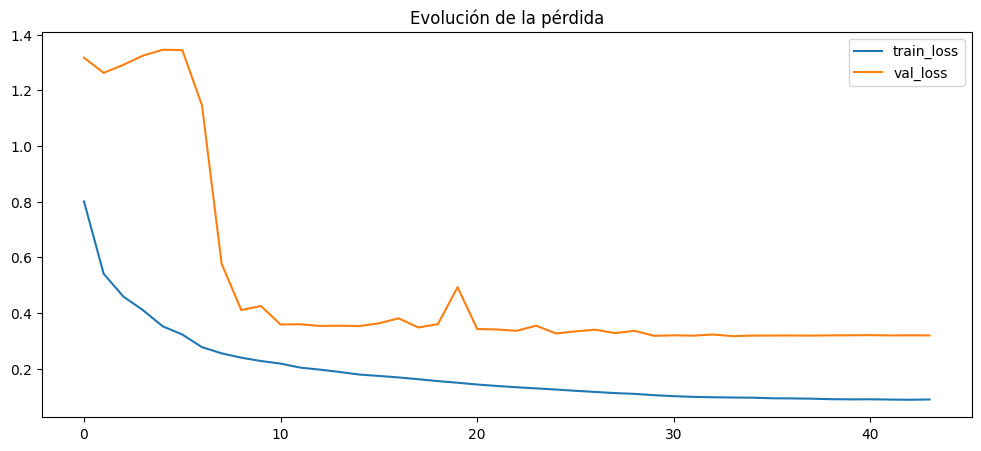

In [15]:
#12. Gráfica del aprendizaje

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Evolución de la pérdida")
plt.show()